# 🚀Demo for read_parquet() optimization
The data we'll be working with is the [Parking Violations Issued - Fiscal Year 2022](https://data.cityofnewyork.us/City-Government/Parking-Violations-Issued-Fiscal-Year-2022/7mxj-7a6y/about_data) dataset from NYC Open Data.

👉 It's recommended that you check out the [article](https://fireducks-dev.github.io/posts/lazy_execution_offering_part1/) before trying the notebook for better understanding of the context.

In [1]:
!pip install -U fireducks

In [2]:
# set environment variable to produce before and after IR
import os
os.environ["FIRE_LOG_LEVEL"] = "3"

In [3]:
import pandas as pd
import fireducks.pandas as fd

# to show exact FireDucks version when printing fd.__version__
from fireducks.core import set_fireducks_option
set_fireducks_option("fireducks-version", True)

## ✅ Let's check the evaluation environment

In [4]:
import platform, psutil
print("="*30, "Evaluation Environment Information", "="*30)
print(f'platform: {platform.system()}')
print(f'architecture: {platform.machine()}')
print(f'processor: {platform.processor()}')
print(f'cpu: {psutil.cpu_count()}')
print(f'pandas version: {pd.__version__}')
print(f'FireDucks version: {fd.__version__}')

============================== Evaluation Environment Information ==============================
platform: Linux
architecture: x86_64
processor: x86_64
cpu: 128
pandas version: 2.2.2
FireDucks version: 1.1.2


## 🛠️ Let's experiment with a real dataset

In [5]:
# Data can be downloaded from here:
!wget https://data.rapids.ai/datasets/nyc_parking/nyc_parking_violations_2022.parquet

--2024-12-05 19:56:27--  https://data.rapids.ai/datasets/nyc_parking/nyc_parking_violations_2022.parquet
proxygate1.nic.nec.co.jp (proxygate1.nic.nec.co.jp) をDNSに問いあわせています... 10.51.8.102, 10.51.8.101
proxygate1.nic.nec.co.jp (proxygate1.nic.nec.co.jp)|10.51.8.102|:8080 に接続しています... 接続しました。
Proxy による接続要求を送信しました、応答を待っています... 200 OK
長さ: 474211285 (452M) [binary/octet-stream]
‘nyc_parking_violations_2022.parquet.25’ に保存中

nyc_parking_violati 100%[===================>] 452.24M  30.9MB/s    in 15s     

2024-12-05 19:56:45 (30.0 MB/s) - ‘nyc_parking_violations_2022.parquet.25’ へ保存完了 [474211285/474211285]



### 📈 Let's plot top-10 vehicle body types that are most frequently involved in parking violations (using pandas)

CPU times: user 16.1 s, sys: 17.5 s, total: 33.6 s
Wall time: 10.5 s


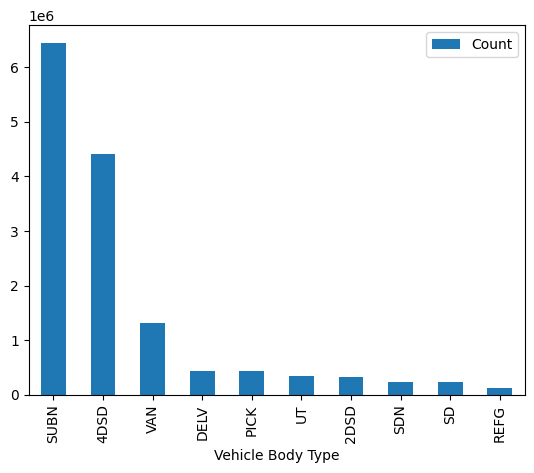

In [6]:
%%time
(
    pd.read_parquet("nyc_parking_violations_2022.parquet")
      .groupby("Vehicle Body Type")    
      .agg(Count=("Summons Number", "count"))
      .sort_values(by="Count", ascending=False)
      .head(10)
      .plot(kind="bar")
);

### 📈 Let's plot top-10 vehicle body types that are most frequently involved in parking violations (using FireDucks)

2024-12-05 19:56:56.339672: 1004552 fireducks/lib/fireducks_core.cc:64] Input IR:
func @main() {
  %t0 = read_parquet('nyc_parking_violations_2022.parquet', [])
  %t1 = groupby_agg(%t0, ['Vehicle Body Type'], ['count'], ['Summons Number'], ['Count'])
  %t2 = sort_values(%t1, ['Count'], [0])
  %t3 = slice(%t2, 0, 10, 1)
  %v4, %v5 = to_pandas.frame.metadata(%t3)
  return(%t3, %v4, %v5)
}
2024-12-05 19:56:56.340383: 1004552 fireducks/lib/fireducks_core.cc:73] Optimized IR:
func @main() {
  %t0 = read_parquet('nyc_parking_violations_2022.parquet', ['Vehicle Body Type', 'Summons Number'])
  %t1 = groupby_agg(%t0, ['Vehicle Body Type'], ['count'], ['Summons Number'], ['Count'])
  %t2 = sort_values(%t1, ['Count'], [0])
  %t3 = slice(%t2, 0, 10, 1)
  %v4, %v5 = to_pandas.frame.metadata(%t3)
  return(%t3, %v4, %v5)
}


CPU times: user 983 ms, sys: 127 ms, total: 1.11 s
Wall time: 199 ms


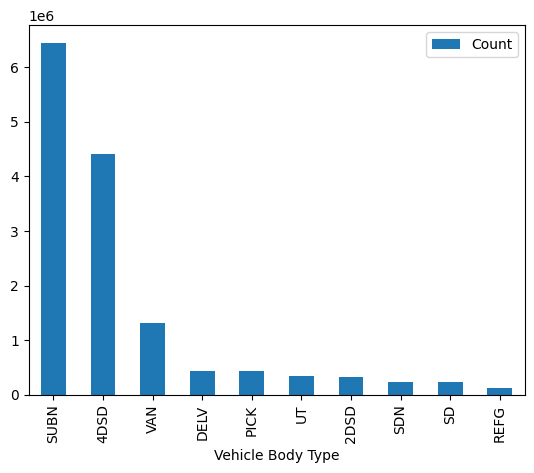

In [7]:
%%time
(
    fd.read_parquet("nyc_parking_violations_2022.parquet")
      .groupby("Vehicle Body Type")
      .agg(Count=("Summons Number", "count"))
      .sort_values(by="Count", ascending=False)
      .head(10)
      .plot(kind="bar")
);

## 🚀🚀 Speed-up

Execution time reduced from ~10s to ~220ms (45x) when running the same program using FireDucks.
It shows how efficiently the FireDucks JIT compiler optimized the sample query by reducing the data loading overhead and parallelizing the workload without affecting the final result

## 📜 Let's now work with a sample data to understand some Do's and Dont's when using notebook

In [8]:
df = pd.DataFrame(
    {
        "a": [1, 2, 3, 4, 5, 6, 7, 8],
        "b": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
        "c": [1, 4, 9, 16, 25, 36, 49, 64],
        "x": [0, 1, 1, 0, 1, 1, 0, 1],
        "y": ["t1", "t2", "t3", "t1", "t2", "t1", "t2", "t3"],
        "z": [10, 20, 30, 40, 50, 60, 70, 80],
    }
)
df.to_parquet("sample_data.parquet", index=False)

### ✔️ **Use method-chaining to get maximum benefit of FireDucks JIT optimization**

When writting a query in a chained expression, FireDucks compiler can optimize it efficiently, since all the intermediate results while processing the chain are guaranteed to have no later usage and it can only return the final result computed through the optimized data flow.

In [9]:
fd.read_parquet("sample_data.parquet").pipe(lambda df: df[df["x"] == 1])["c"].sum()

2024-12-05 19:56:56.654127: 1004552 fireducks/passes/fireducks_opt_mv_projection.cc:1011] Optimize Projection (fireducks.filter): loc("-":17:18)


2024-12-05 19:56:56.653597: 1004552 fireducks/lib/fireducks_core.cc:64] Input IR:
func @main() {
  %t0 = read_parquet('sample_data.parquet', [])
  %t1 = project(%t0, 'x')
  %t2 = eq.vector.scalar(%t1, 1)
  %t3 = filter(%t0, %t2)
  %t4 = project(%t3, 'c')
  %v5 = aggregate_column.scalar(%t4, 'sum')
  return(%t4, %v5)
}
2024-12-05 19:56:56.654127: 1004552 fireducks/passes/fireducks_opt_mv_projection.cc:1011] Optimize Projection (fireducks.filter): loc("-":17:18)
2024-12-05 19:56:56.654330: 1004552 fireducks/lib/fireducks_core.cc:73] Optimized IR:
func @main() {
  %t0 = read_parquet('sample_data.parquet', ['x', 'c'])
  %t1 = project(%t0, 'x')
  %t2 = eq.vector.scalar(%t1, 1)
  %t3 = project(%t0, ['c'])
  %t4 = filter(%t3, %t2)
  %t5 = project(%t4, 'c')
  %v6 = aggregate_column.scalar(%t5, 'sum')
  return(%t5, %v6)
}


138

### ❌ **Save intermediate results in temporary variables**

When saving intermediate results in temporary variables of present cell, the compiler will assume that they might have some later usage in some another cell execution. Hence, it will keep all of them alive and the optimization will be ineffective.

※ It will not be applicable for a python script though, since the compiler can inspect all the later usage of "df" and "fdf" in that case.

In [10]:
df = fd.read_parquet("sample_data.parquet")
fdf = df[df["x"] == 1]
fdf["c"].sum()

2024-12-05 19:56:56.664294: 1004552 fireducks/lib/fireducks_core.cc:64] Input IR:
func @main() {
  %t0 = read_parquet('sample_data.parquet', [])
  %t1 = project(%t0, 'x')
  %t2 = eq.vector.scalar(%t1, 1)
  %t3 = filter(%t0, %t2)
  %t4 = project(%t3, 'c')
  %v5 = aggregate_column.scalar(%t4, 'sum')
  return(%t4, %v5, %t0, %t3)
}
2024-12-05 19:56:56.664800: 1004552 fireducks/lib/fireducks_core.cc:73] Optimized IR:
func @main() {
  %t0 = read_parquet('sample_data.parquet', [])
  %t1 = project(%t0, 'x')
  %t2 = eq.vector.scalar(%t1, 1)
  %t3 = filter(%t0, %t2)
  %t4 = project(%t3, 'c')
  %v5 = aggregate_column.scalar(%t4, 'sum')
  return(%t4, %v5, %t0, %t3)
}


138